In [76]:
# Necessary setup.
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices("GPU"):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware acceleratot.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")
import numpy as np
import os 
from pathlib import Path

np.random.seed(42)
rng = np.random.default_rng(42)  # For newer NumPy (>=1.17)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#  Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


Basic RNN.

In [77]:
# Generate the Dataset
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series  += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)

In [78]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train,  y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000, :n_steps], series[9000:,-1]

In [79]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


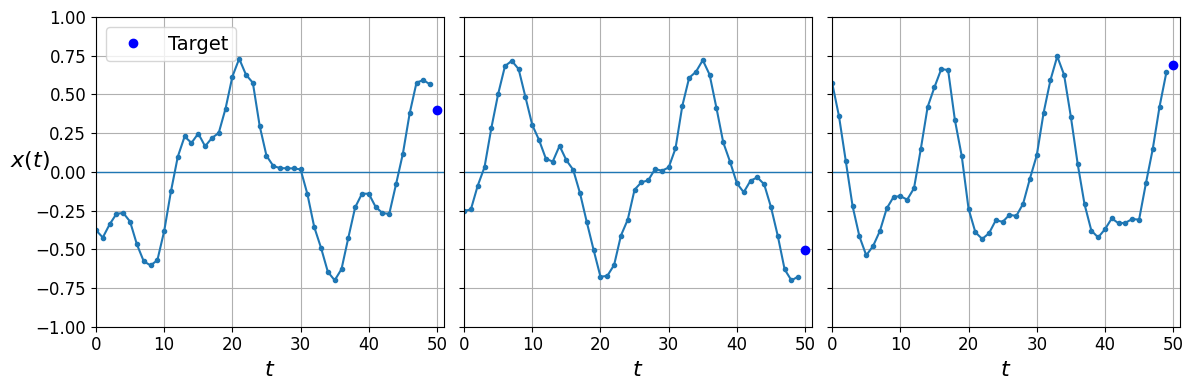

In [80]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True) 
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)    
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left") 

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], 
                y_label=("$x(t)$" if col==0 else None), 
                legend=(col==0))
save_fig("time_series_plot")
plt.show()                



Computing some Baselines.

In [81]:
mse = keras.losses.MeanSquaredError()
mse_value = mse(y_valid, y_pred).numpy()
print(mse_value)


0.002545586


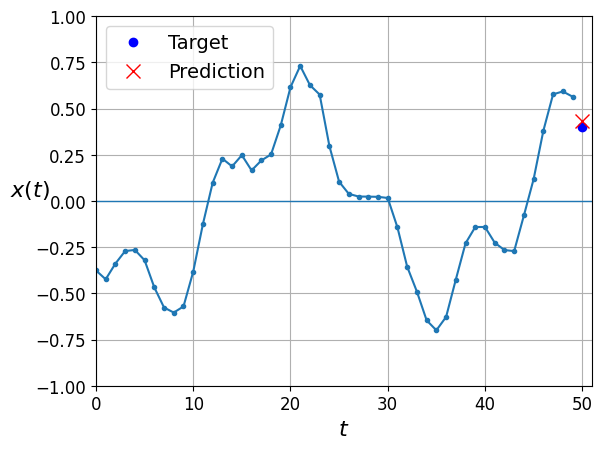

In [82]:
plot_series(X_valid[0, :, 0],y_valid[0,0], y_pred[0, 0])

In [83]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]), 
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


c:\Users\ADMIN\Desktop\Jupyter Projects\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2699 - val_loss: 0.0996
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0816 - val_loss: 0.0502
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0441 - val_loss: 0.0294
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271 - val_loss: 0.0201
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - val_loss: 0.0158
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0152 - val_loss: 0.0134
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - val_loss: 0.0118
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0106
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

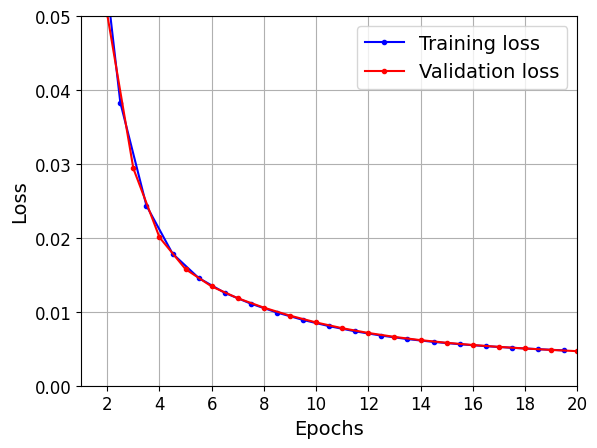

In [84]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()    

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


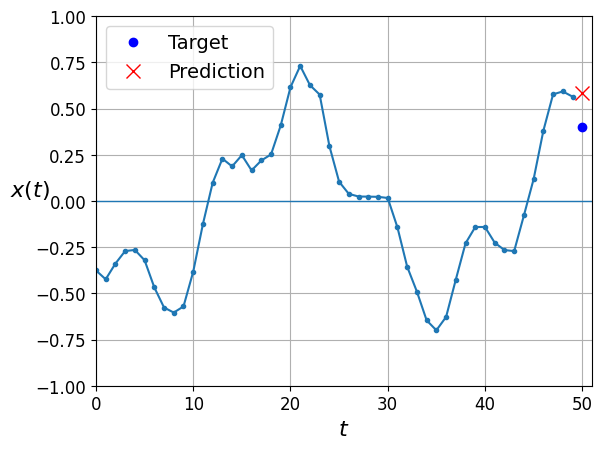

In [85]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Using a Simple RNN

In [86]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


c:\Users\ADMIN\Desktop\Jupyter Projects\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1617 - val_loss: 0.1527
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1383 - val_loss: 0.0616
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0492 - val_loss: 0.0322
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0292 - val_loss: 0.0233
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0221 - val_loss: 0.0188
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.0160
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - val_loss: 0.0142
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0121
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0

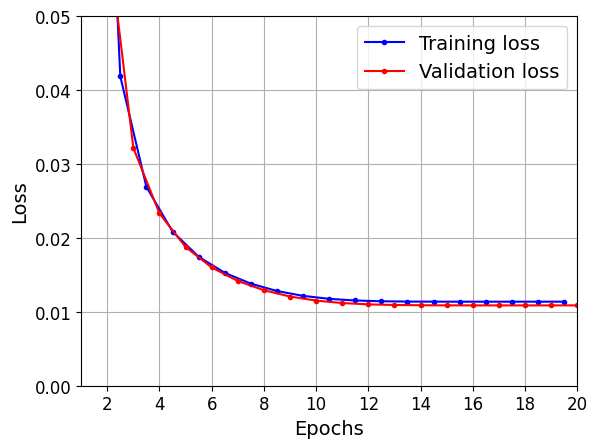

In [87]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

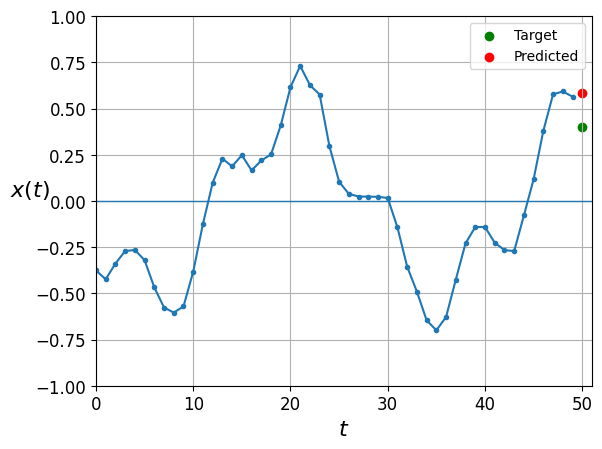

In [88]:
plot_series(X_valid[0, :, 0])
plt.scatter(len(X_valid[0, :, 0]), y_valid[0, 0], color="green", label="Target")
plt.scatter(len(X_valid[0, :, 0]), y_pred[0][0], color="red", label="Predicted")
plt.legend()
plt.show()


Deep RNN

In [89]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)

])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

c:\Users\ADMIN\Desktop\Jupyter Projects\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.1251 - val_loss: 0.0106
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0101 - val_loss: 0.0062
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 4/20
122/219 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0050

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026


0.0028020311146974564

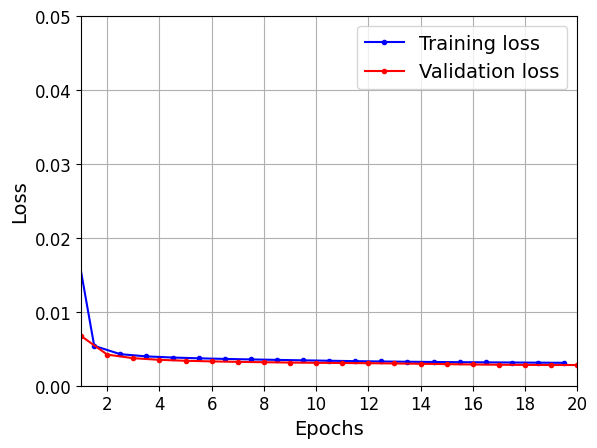

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


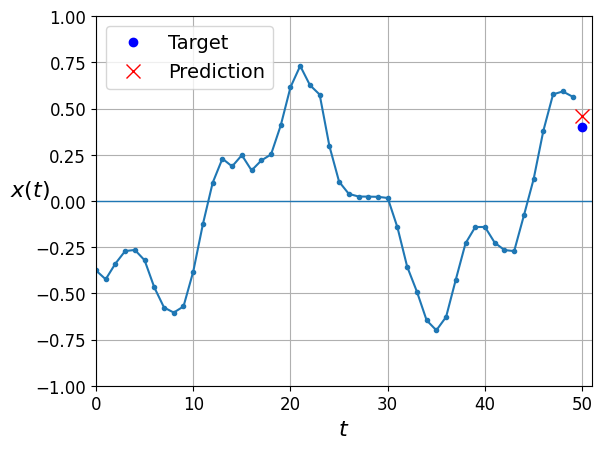

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0,0])
plt.show()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model  = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


c:\Users\ADMIN\Desktop\Jupyter Projects\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0154 - val_loss: 0.0033
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/ste

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024


0.0025455858558416367

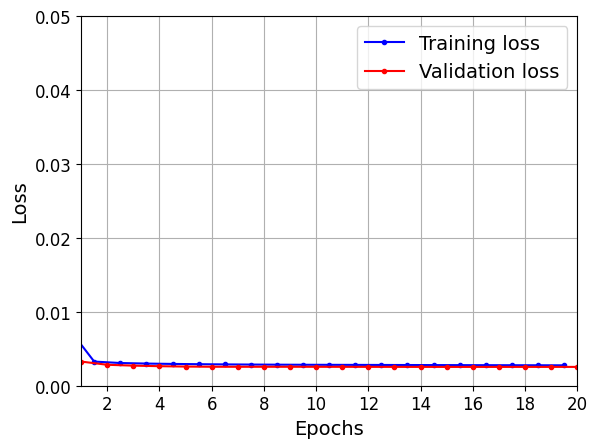

In [ ]:
plot_learning_curves(history.history["loss"],  history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


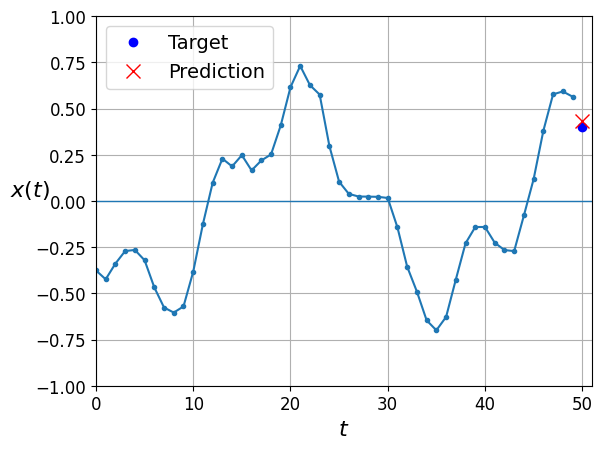

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Forecasting several steps ahead.


In [ ]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new , Y_new =series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [ ]:
Y_pred.shape

(1, 10, 1)

In [92]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]

    # Handle 2D vs 3D for X
    if X.ndim == 3:
        x_series = X[0, :, 0]
    else:  # assume 2D
        x_series = X[0, :]

    plot_series(x_series)

    # Handle 2D vs 3D for Y and Y_pred
    if Y.ndim == 3:
        y_actual = Y[0, :, 0]
    else:
        y_actual = Y[0, :]

    if Y_pred.ndim == 3:
        y_forecast = Y_pred[0, :, 0]
    else:
        y_forecast = Y_pred[0, :]

    plt.plot(np.arange(n_steps, n_steps + ahead), y_actual, "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), y_forecast, "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


In [93]:
# Now we use this model to predict next 10 values.We first need to regenerate
# the sequences with 9 more time steps
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid , Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test ,Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
# Now we predict the next 10 values one by one.
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
Y_pred.shape

(2000, 10)

In [ ]:
# np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

# In this new version mean_squared_error() is not directly callable.
from tensorflow.keras.metrics import MeanSquaredError

# Create the metric object
mse_fn = MeanSquaredError()
# Call it on your predictions
mse_fn.update_state(Y_valid, Y_pred)
# Get the result
mse_value = mse_fn.result().numpy()
print("MSE:", mse_value)


MSE: 0.017992534


In [ ]:
# Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value and repeat it 10 times.
# np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred)) 

Y_naive_pred = np.repeat(X_valid[:, -1].reshape(-1, 1), repeats=10, axis=1)

mse = MeanSquaredError()
mse_value = mse(Y_valid, Y_naive_pred).numpy()
print("Naive MSE:", mse_value)


Naive MSE: 0.25697407


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20


c:\Users\ADMIN\Desktop\Jupyter Projects\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2084 - val_loss: 0.1571
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0762 - val_loss: 0.1546
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0632 - val_loss: 0.1560
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0579 - val_loss: 0.1575
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0543 - val_loss: 0.1593
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0515 - val_loss: 0.1613
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0494 - val_loss: 0.1634
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0477 - val_loss: 0.1655
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0463 - val_loss: 0.1674
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0451 - val_loss: 0.1692
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0442 - val_loss: 0.1708
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model  = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
    
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1003 - val_loss: 0.0279
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0262 - val_loss: 0.0192
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0194 - val_loss: 0.0170
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0109 - val_loss: 0.0099
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0106 - val_loss: 0.0096
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [90]:
Series = generate_time_series(1, 50 + 10)
X_new , Y_new =series[:, :50, :], series[:, -10, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


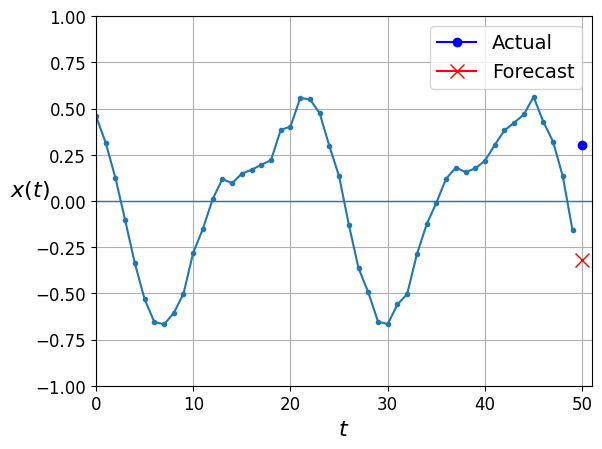

In [94]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [97]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train =series[:7000,:n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y

In [98]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [108]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# Custom metric for last time step MSE
def last_time_step_mse(Y_true, Y_pred):
    return K.mean(K.square(Y_true[:, -1] - Y_pred[:, -1]))

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[last_time_step_mse]
)

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - last_time_step_mse: 0.0550 - loss: 0.0631 - val_last_time_step_mse: 0.0206 - val_loss: 0.0350
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - last_time_step_mse: 0.0230 - loss: 0.0358 - val_last_time_step_mse: 0.0158 - val_loss: 0.0305
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - last_time_step_mse: 0.0184 - loss: 0.0313 - val_last_time_step_mse: 0.0146 - val_loss: 0.0279
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - last_time_step_mse: 0.0163 - loss: 0.0286 - val_last_time_step_mse: 0.0138 - val_loss: 0.0258
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - last_time_step_mse: 0.0146 - loss: 0.0267 - val_last_time_step_mse: 0.0133 - val_loss: 0.0250
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - last_time_step_mse: 0.0127 - loss: 0.0251 - val_last_time_step_mse: 0.0091 - val_loss: 0.0220
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - last_time_step_mse: 0.0099 - loss: 0.0228 - val_la

In [117]:

np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


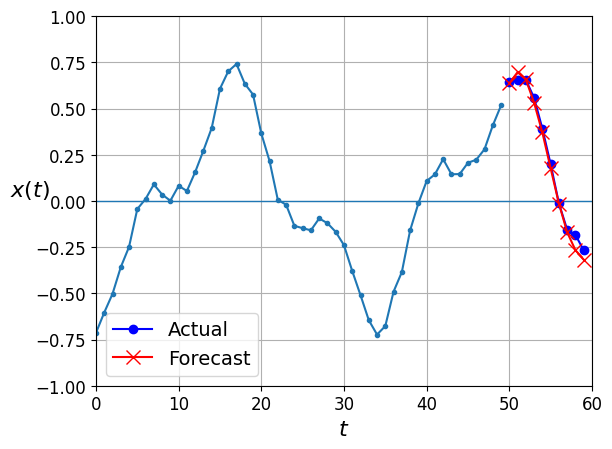

In [118]:
plot_multiple_forecasts(X_new,Y_new, Y_pred)
plt.show()

Deep RNN with Batch Norm

In [120]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))

])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history= model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - last_time_step_mse: 0.3949 - loss: 0.4107 - val_last_time_step_mse: 0.0701 - val_loss: 0.0847
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - last_time_step_mse: 0.0454 - loss: 0.0568 - val_last_time_step_mse: 0.0410 - val_loss: 0.0520
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - last_time_step_mse: 0.0363 - loss: 0.0474 - val_last_time_step_mse: 0.0327 - val_loss: 0.0442
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - last_time_step_mse: 0.0314 - loss: 0.0427 - val_last_time_step_mse: 0.0282 - val_loss: 0.0406
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0272 - loss: 0.0391 - val_last_time_step_mse: 0.0250 - val_loss: 0.0369
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0248 - loss: 0.0368 - val_last_time_step_mse: 0.0236 - val_loss: 0.0352
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - last_time_step_mse: 0.0233 - loss: 0.0352 - val_la

Deep RNNs with Layer Norm

In [121]:
from tensorflow.keras.layers import LayerNormalization

In [122]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtyp=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]            

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

LSTM

In [126]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
histroy = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20


c:\Users\ADMIN\Desktop\Jupyter Projects\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - last_time_step_mse: 0.0859 - loss: 0.0972 - val_last_time_step_mse: 0.0351 - val_loss: 0.0539
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - last_time_step_mse: 0.0311 - loss: 0.0503 - val_last_time_step_mse: 0.0200 - val_loss: 0.0413
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - last_time_step_mse: 0.0188 - loss: 0.0397 - val_last_time_step_mse: 0.0155 - val_loss: 0.0361
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - last_time_step_mse: 0.0154 - loss: 0.0354 - val_last_time_step_mse: 0.0143 - val_loss: 0.0336
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - last_time_step_mse: 0.0139 - loss: 0.0330 - val_last_time_step_mse: 0.0131 - val_loss: 0.0316
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0128 - loss: 0.0312 - val_last_time_step_mse: 0.0123 - val_loss: 0.0301
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0119 - loss: 0.0298 - val_last_time_ste

In [127]:
model.evaluate(X_valid, Y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - last_time_step_mse: 0.0092 - loss: 0.0236


[0.023677414283156395, 0.009456690400838852]

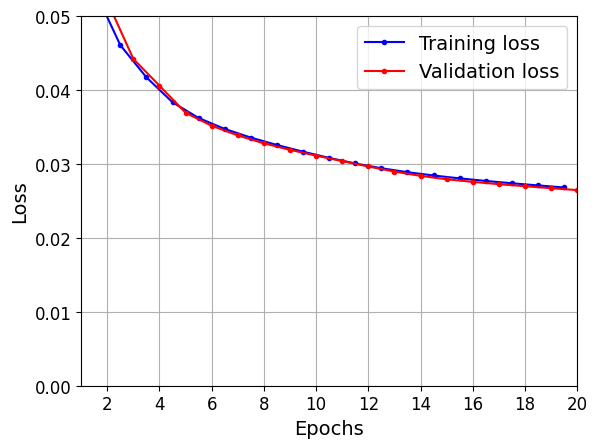

In [128]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [129]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


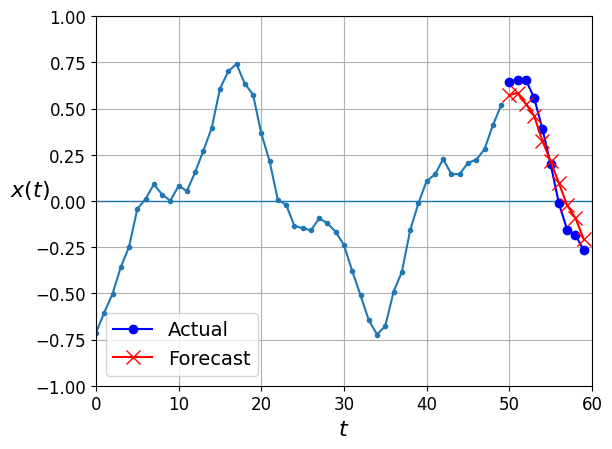

In [130]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()